Make sure graphviz (see README) is installed and added to PATH
Run the following commands to install all packages
pip install matplotlib
pip install numpy
pip install pandas
pip install seaborn
pip install keras
pip install sklearn
pip install tensorflow

Imports

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow
from keras.layers import Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Reading CSV

In [43]:
gdp_data = pd.read_csv(r'..\gdp_csv.csv')
internet_speed_data = pd.read_csv(r'..\internet_speeds.csv', sep=";")
internet_access_data = pd.read_csv(r'..\internet_access.csv')
unemployment_data = pd.read_csv(r'..\unemployment.csv', on_bad_lines='skip')
military_data = pd.read_csv(r'..\military_expenditure.csv')
happy_data = pd.read_csv(r'..\world_happiness_report_2022.csv', decimal=",", sep=";")
country_codes_data = pd.read_csv(r'..\country_codes.csv', sep=";")

gdp = pd.DataFrame(gdp_data, columns=['Country Code', 'Value', 'Year'])
internet_speed = pd.DataFrame(internet_speed_data, columns=['Country','Broadband Mbps', 'Mobile Mbps', 'As of'])
internet_access = pd.DataFrame(internet_access_data, columns=['Country Code', '2020'])
unemployment = pd.DataFrame(unemployment_data, columns=['Country Code','2021'])
military = pd.DataFrame(military_data, columns=['Code', '2018'])
happy = pd.DataFrame(happy_data, columns=['Country', 'Happiness score'])
country_codes = pd.DataFrame(country_codes_data, columns=['Country', 'Alpha-3 code'])
unemployment.head(2000)

,Country Code,2021
0,ABW,NaN
1,AFE,8.111783
2,AFG,13.283000
3,AFW,6.839009
4,AGO,8.530000
...,...,...
261,XKX,NaN
262,YEM,13.574000
263,ZAF,33.558998
264,ZMB,13.026000


Renaming

In [44]:
gdp.rename(columns = {'Country Code':'CountryCode', 'Year':'YearGDP', 'Value':'GDP'}, inplace = True)
internet_speed.rename(columns = {'Country':'CountryName', 'Broadband Mbps':'BroadbandSpeed', 'Mobile Mbps':'MobileSpeed', 'As of':'YearInternetSpeed'}, inplace = True)
internet_access.rename(columns={'Country Code':'CountryCode', '2020':'InternetAccess2020'}, inplace= True)
unemployment.rename(columns= {'Country Code':'CountryCode', '2021':'Unemployment2021'}, inplace=True)
military.rename(columns= {'Code':'CountryCode', '2018':'MilitarySpending2018'}, inplace=True)
happy.rename(columns= {'Country':'CountryName', 'Happiness score':'HappinessScore2022'}, inplace=True)
country_codes.rename(columns= {'Alpha-3 code':'CountryCode', 'Country':'CountryName'}, inplace=True)

Removing unused Values

In [45]:
country_codes['CountryCode'] = country_codes['CountryCode'].replace({'"':''}, regex=True)
happy['CountryName'] = happy['CountryName'].replace({'\*':''}, regex=True)

Removing Duplicates

In [46]:
gdp.sort_values(by=['CountryCode','YearGDP'], ascending=False, inplace=True)
internet_speed.sort_values(by=['CountryName','YearInternetSpeed'], ascending=False, inplace=True)

gdp.drop_duplicates(subset=['CountryCode'], keep='first', inplace=True)
internet_speed.drop_duplicates(subset=['CountryName'], keep='first', inplace=True)

Convert Units & Round

In [47]:
gdp['GDP'] = gdp['GDP'].div(1000000000).round(2)
military['MilitarySpending2018'] = military['MilitarySpending2018'].div(1000000).round(2)

Merging

In [48]:
internet_speed = pd.merge(internet_speed, country_codes, how='left', on='CountryName')
happy = pd.merge(happy, country_codes, how='left', on='CountryName')
happy.drop('CountryName', axis=1, inplace=True)
internet_speed['CountryCode'] = internet_speed['CountryCode'].str.strip()
happy['CountryCode'] = happy['CountryCode'].str.strip()
internet_access['CountryCode'] = internet_access['CountryCode'].str.strip()
unemployment['CountryCode'] = unemployment['CountryCode'].str.strip()
military['CountryCode'] = military['CountryCode'].str.strip()
dataset = pd.merge(internet_speed, gdp, how='left', on = 'CountryCode')
dataset = pd.merge(dataset, internet_access, how='left', on='CountryCode')
dataset = pd.merge(dataset, unemployment, how='left', on='CountryCode')
dataset = pd.merge(dataset, military, how='left', on='CountryCode')
dataset = pd.merge(dataset, happy, how='left', on='CountryCode')
dataset.head(2000)

,CountryName,BroadbandSpeed,MobileSpeed,YearInternetSpeed,CountryCode,GDP,YearGDP,InternetAccess2020,Unemployment2021,MilitarySpending2018,HappinessScore2022
0,Zimbabwe,5.21,12.02,January 2022,ZWE,16.62,2016.0,29.30,5.174,420.36,2.995
1,Zambia,4.60,12.46,January 2022,ZMB,21.06,2016.0,19.80,13.026,378.03,3.760
2,Yemen,2.74,0.53,January 2022,YEM,27.32,2016.0,NaN,13.574,NaN,4.197
3,Western Sahara,10.51,NaN,January 2022,ESH,NaN,NaN,NaN,NaN,NaN,NaN
4,Vietnam,67.50,39.01,January 2022,VNM,205.28,2016.0,70.30,2.166,5500.00,5.485
...,...,...,...,...,...,...,...,...,...,...,...
175,Angola,11.97,25.43,January 2022,AGO,95.34,2016.0,36.00,8.530,1983.61,NaN
176,Andorra,92.42,NaN,January 2022,AND,2.86,2016.0,NaN,NaN,NaN,NaN
177,Algeria,9.72,11.31,January 2022,DZA,159.05,2016.0,62.90,12.704,9583.72,5.122
178,Albania,33.50,35.62,January 2022,ALB,11.86,2016.0,72.24,11.819,180.49,5.199


GDP - Broadband Speed

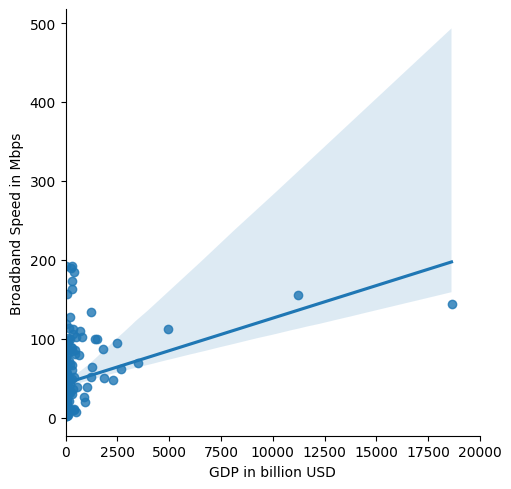

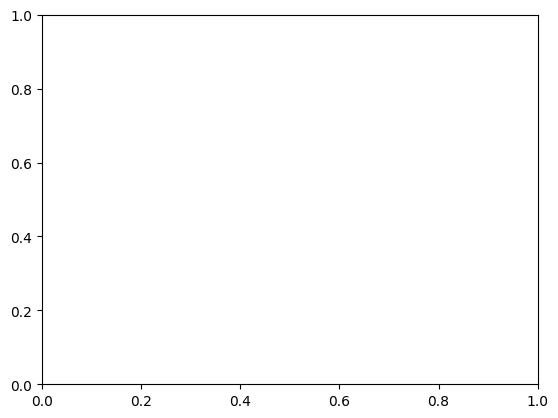

In [49]:
plotBroadBand = sns.lmplot(x="GDP", y="BroadbandSpeed", data=dataset)
plotBroadBand.set_xlabels('GDP in billion USD')
plotBroadBand.set_ylabels('Broadband Speed in Mbps')
plt.xlim(0, 20000)
plotBroadBand.savefig(r'..\output\GDP - Broadband Speed.png')
plt.show()

GDP - Mobile Speed

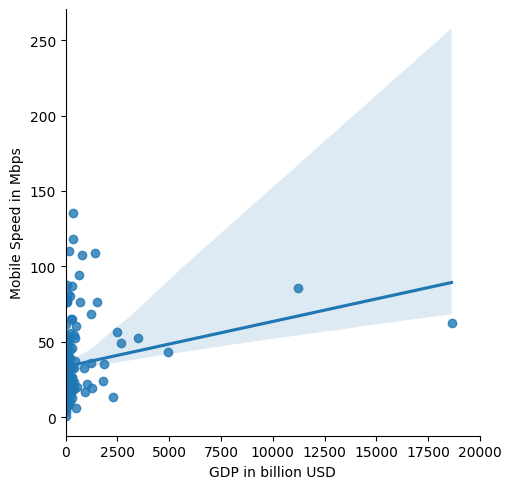

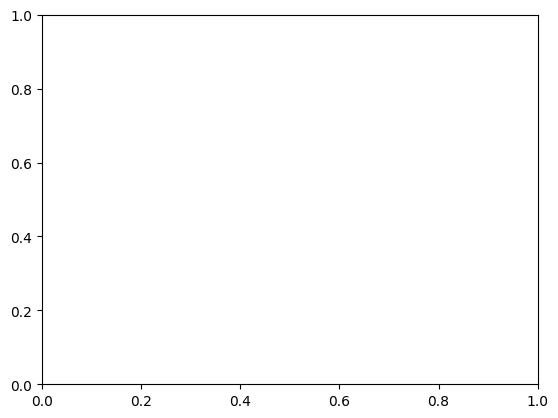

In [50]:
plotBroadBand = sns.lmplot(x="GDP", y="MobileSpeed", data=dataset)
plotBroadBand.set_xlabels('GDP in billion USD')
plotBroadBand.set_ylabels('Mobile Speed in Mbps')
plt.xlim(0, 20000)
plotBroadBand.savefig(r'..\output\GDP - Mobile Speed.png')
plt.show()

Internet Access - Mobile Speed

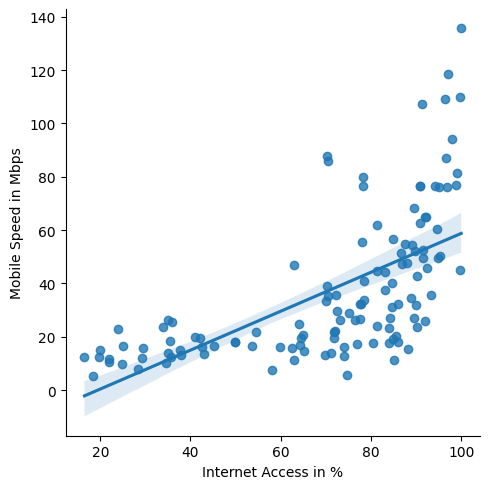

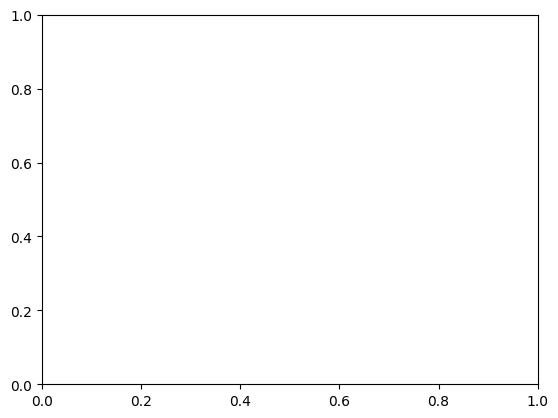

In [51]:
plotBroadBand = sns.lmplot(x="InternetAccess2020", y="MobileSpeed", data=dataset)
plotBroadBand.set_xlabels('Internet Access in %')
plotBroadBand.set_ylabels('Mobile Speed in Mbps')
plotBroadBand.savefig(r'..\output\Internet Access - Mobile Speed.png')
plt.show()

Internet Access - Broadband Speed

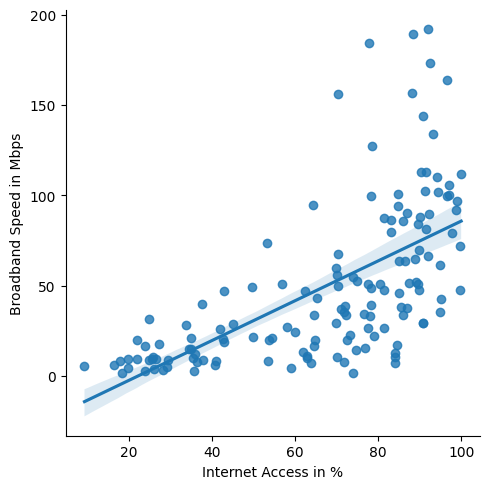

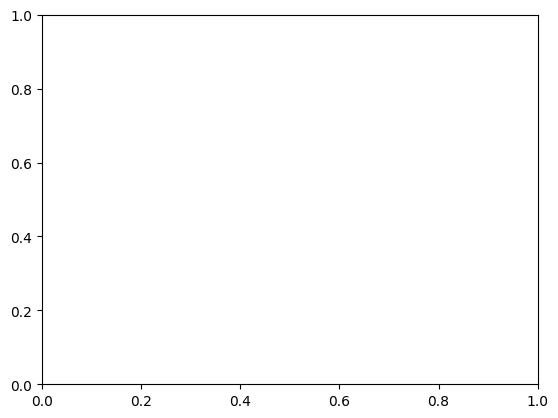

In [52]:
plotBroadBand = sns.lmplot(x="InternetAccess2020", y="BroadbandSpeed", data=dataset)
plotBroadBand.set_xlabels('Internet Access in %')
plotBroadBand.set_ylabels('Broadband Speed in Mbps')
plotBroadBand.savefig(r'..\output\Internet Access - Broadband Speed.png')
plt.show()

Unemployment - Mobile Speed

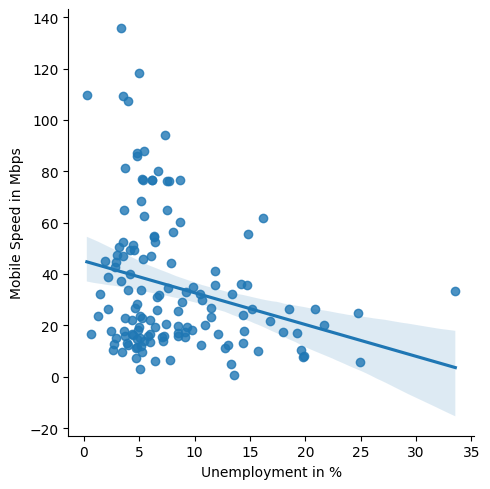

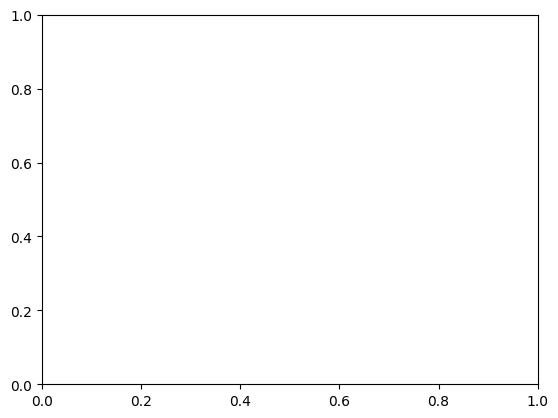

In [53]:
plotBroadBand = sns.lmplot(x="Unemployment2021", y="MobileSpeed", data=dataset)
plotBroadBand.set_xlabels('Unemployment in %')
plotBroadBand.set_ylabels('Mobile Speed in Mbps')
plotBroadBand.savefig(r'..\output\Unemployment - Mobile Speed.png')
plt.show()

Unemployment - Broadband Speed

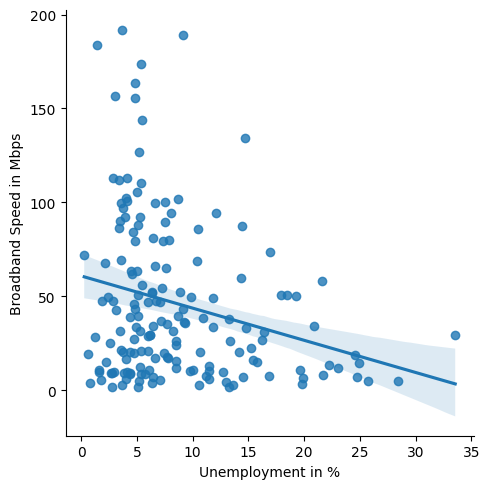

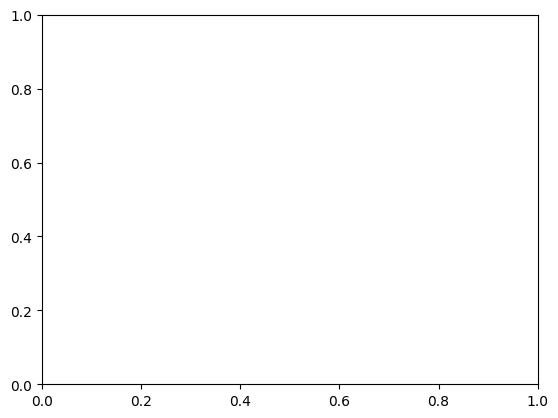

In [54]:
plotBroadBand = sns.lmplot(x="Unemployment2021", y="BroadbandSpeed", data=dataset)
plotBroadBand.set_xlabels('Unemployment in %')
plotBroadBand.set_ylabels('Broadband Speed in Mbps')
plotBroadBand.savefig(r'..\output\Unemployment - Broadband Speed.png')
plt.show()

Military Spending - Broadband Speed

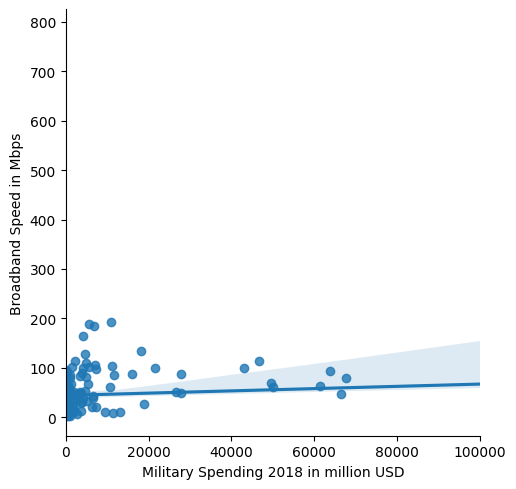

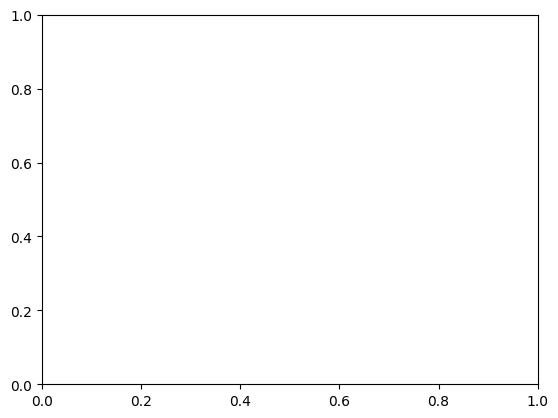

In [55]:
plotBroadBand = sns.lmplot(x="MilitarySpending2018", y="BroadbandSpeed", data=dataset)
plotBroadBand.set_xlabels('Military Spending 2018 in million USD')
plotBroadBand.set_ylabels('Broadband Speed in Mbps')
plt.xlim(0, 100000) #Ohne USA
plotBroadBand.savefig(r'..\output\Military Spending - Broadband Speed.png')
plt.show()

Military Spending - Mobile Speed

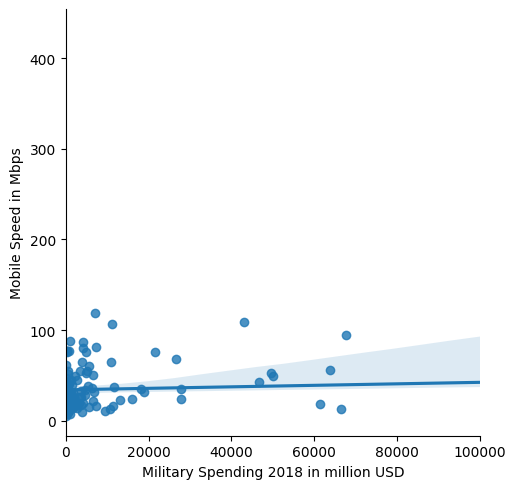

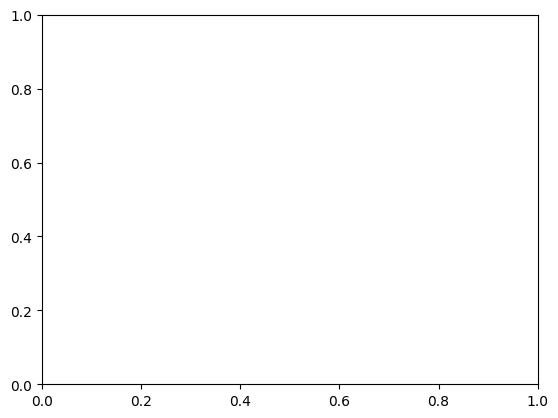

In [56]:
plotBroadBand = sns.lmplot(x="MilitarySpending2018", y="MobileSpeed", data=dataset)
plotBroadBand.set_xlabels('Military Spending 2018 in million USD')
plotBroadBand.set_ylabels('Mobile Speed in Mbps')
plt.xlim(0, 100000) #Ohne USA
plotBroadBand.savefig(r'..\output\Military Spending - Mobile Speed.png')
plt.show()

Happiness Score - Mobile Speed

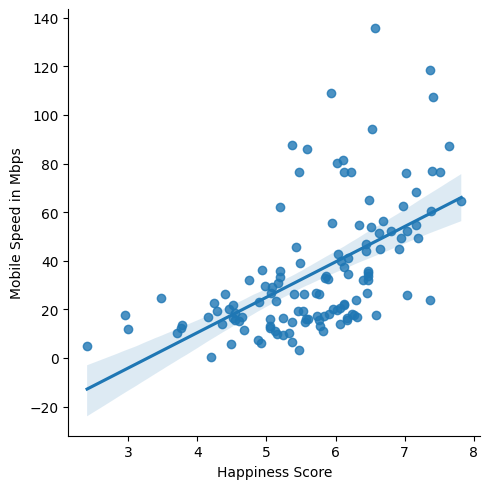

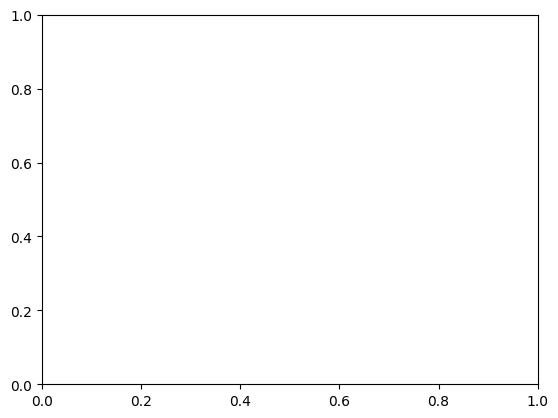

In [57]:
plotBroadBand = sns.lmplot(x="HappinessScore2022", y="MobileSpeed", data=dataset)
plotBroadBand.set_xlabels('Happiness Score')
plotBroadBand.set_ylabels('Mobile Speed in Mbps')
plotBroadBand.savefig(r'..\output\Happiness Score - Mobile Speed.png')
plt.show()

Happiness Score - Broadband Speed

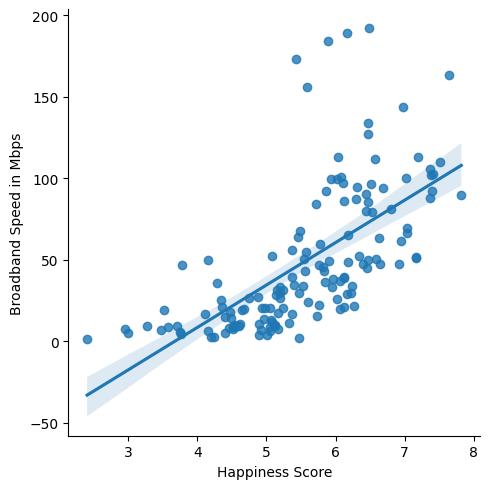

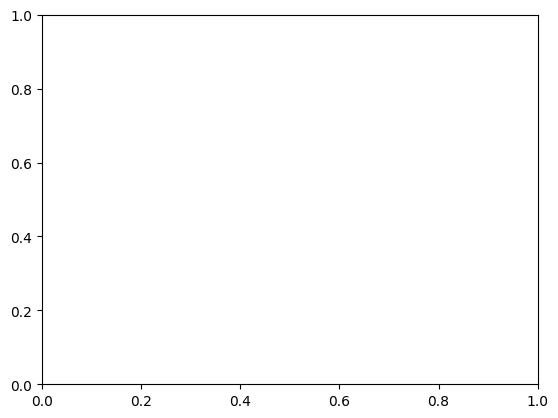

In [58]:
plotBroadBand = sns.lmplot(x="HappinessScore2022", y="BroadbandSpeed", data=dataset)
plotBroadBand.set_xlabels('Happiness Score')
plotBroadBand.set_ylabels('Broadband Speed in Mbps')
plotBroadBand.savefig(r'..\output\Happiness Score - Broadband Speed.png')
plt.show()

Boxplot GDP

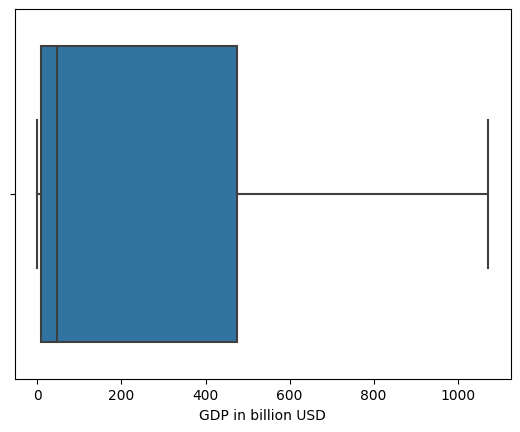

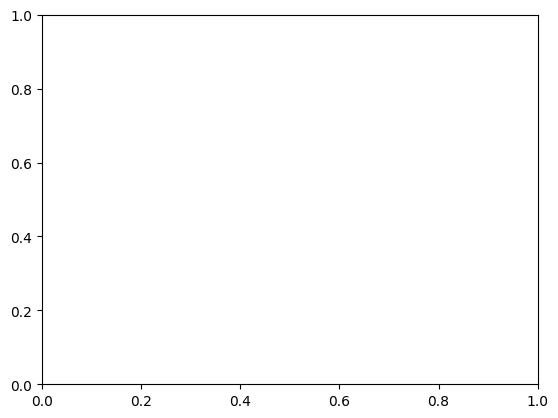

In [59]:
plotBroadBand = sns.boxplot(x=gdp['GDP'], showfliers = False)
#plotBroadBand = sns.swarmplot(x=gdp['GDP'], color="r")
plotBroadBand.set(
    xlabel='GDP in billion USD'
)
plotBroadBand.get_figure().savefig(r'..\output\GDP Boxplot.png')
plt.show()

Boxplot Mobile Speed

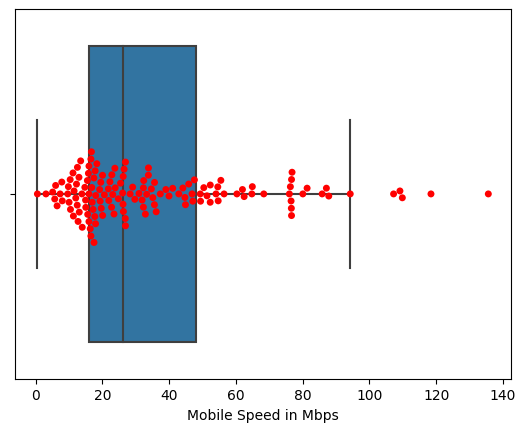

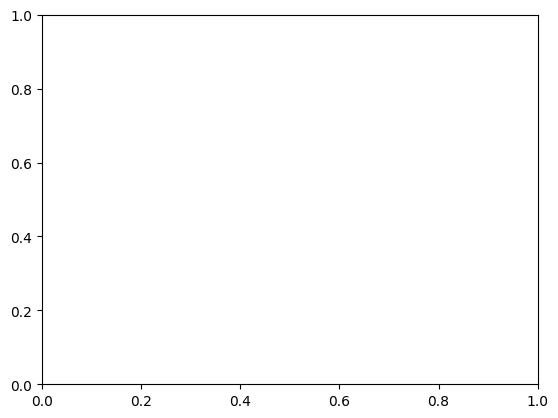

In [60]:
plotBroadBand = sns.boxplot(x=dataset['MobileSpeed'], showfliers= False)
plotBroadBand = sns.swarmplot(x=dataset['MobileSpeed'], color="r")
plotBroadBand.set(
    xlabel='Mobile Speed in Mbps'
)
plotBroadBand.get_figure().savefig(r'..\output\Mobile Speed Boxplot.png')
plt.show()

Boxplot Broadband Speed

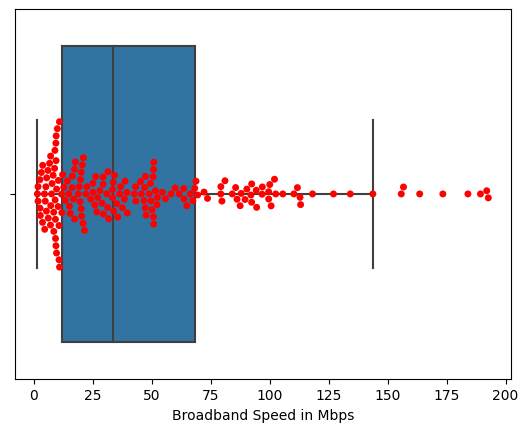

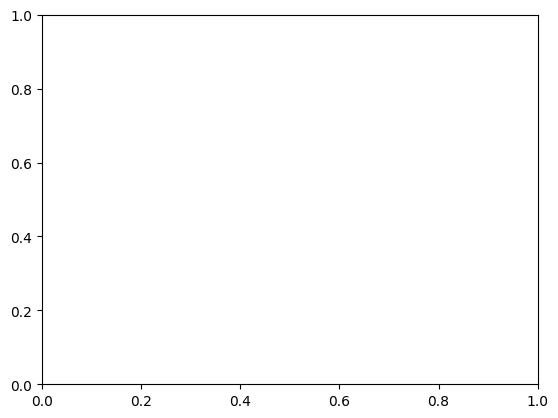

In [61]:
plotBroadBand = sns.boxplot(x=dataset['BroadbandSpeed'], showfliers= False)
plotBroadBand = sns.swarmplot(x=dataset['BroadbandSpeed'], color="r")
plotBroadBand.set(
    xlabel='Broadband Speed in Mbps'
)
plotBroadBand.get_figure().savefig(r'..\output\Broadband Speed Boxplot.png')
plt.show()

Happiness Score Boxplot

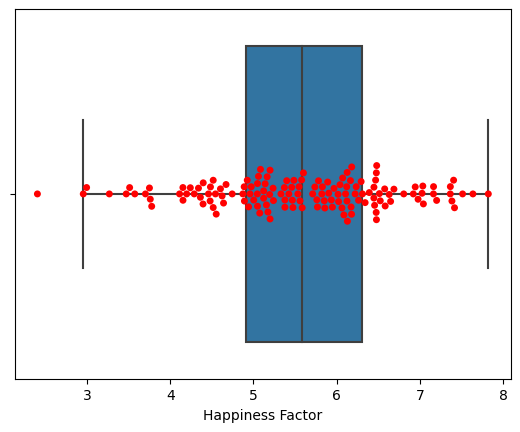

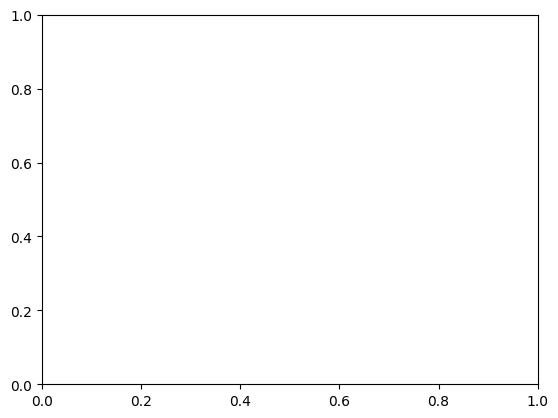

In [62]:
plotBroadBand = sns.boxplot(x=dataset['HappinessScore2022'], showfliers= False)
plotBroadBand = sns.swarmplot(x=dataset['HappinessScore2022'], color="r")
plotBroadBand.set(
    xlabel='Happiness Factor'
)
plotBroadBand.get_figure().savefig(r'..\output\Happiness Boxplot.png')
plt.show()

Unemployment Boxplot

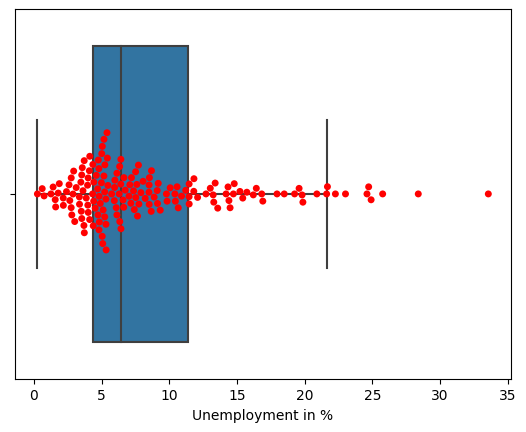

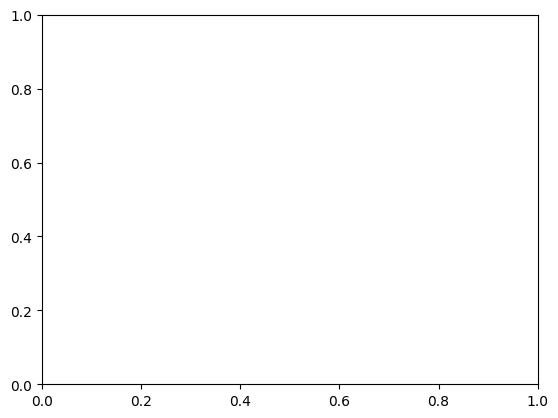

In [63]:
plotBroadBand = sns.boxplot(x=dataset['Unemployment2021'], showfliers= False)
plotBroadBand = sns.swarmplot(x=dataset['Unemployment2021'], color="r")
plotBroadBand.set(
    xlabel='Unemployment in %'
)
plotBroadBand.get_figure().savefig(r'..\output\Unemployment Boxplot.png')
plt.show()

Internet Access Boxplot

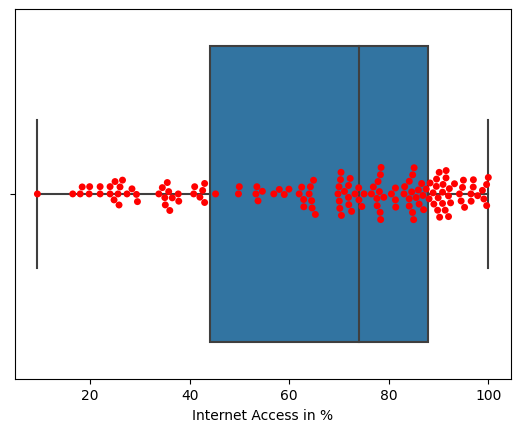

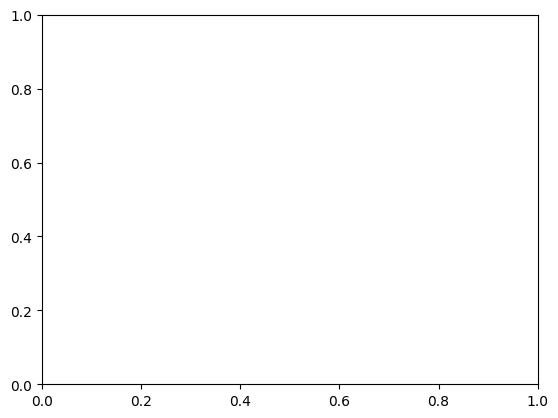

In [64]:
plotBroadBand = sns.boxplot(x=dataset['InternetAccess2020'], showfliers= False)
plotBroadBand = sns.swarmplot(x=dataset['InternetAccess2020'], color="r")
plotBroadBand.set(
    xlabel='Internet Access in %'
)
plotBroadBand.get_figure().savefig(r'..\output\Internet Access Boxplot.png')
plt.show()

Military Spending Boxplot

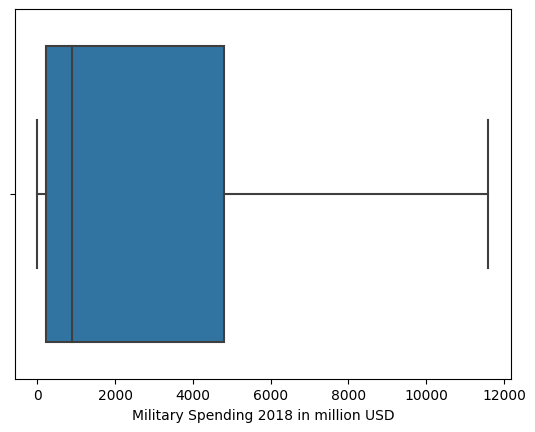

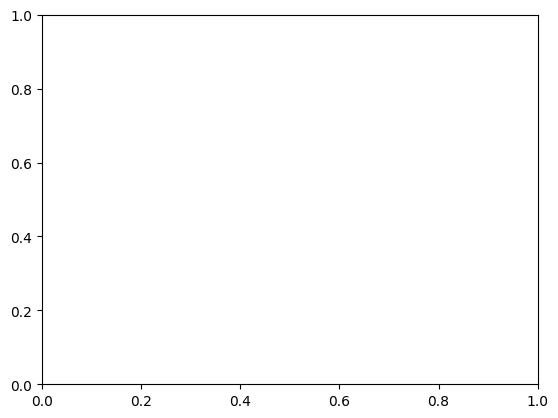

In [65]:
plotBroadBand = sns.boxplot(x=dataset['MilitarySpending2018'], showfliers= False)
#plotBroadBand = sns.swarmplot(x=dataset['MilitarySpending2018'], color="r")
plotBroadBand.set(
    xlabel='Military Spending 2018 in million USD'
)
plotBroadBand.get_figure().savefig(r'..\output\Military Spending Boxplot.png')
plt.show()

NaN Percentage

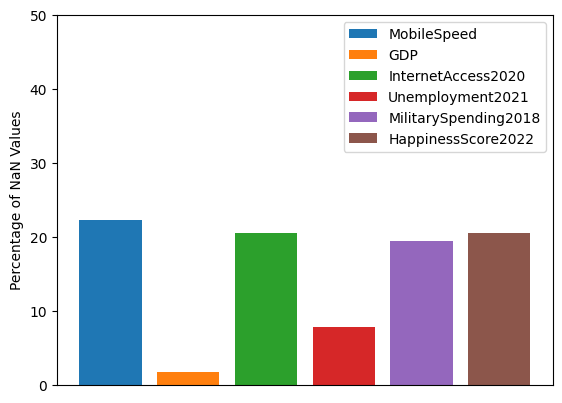

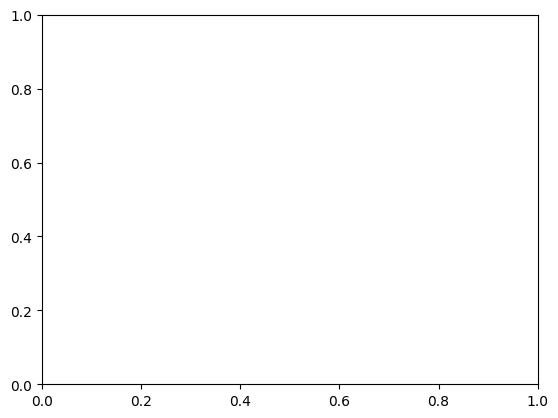

In [66]:
percent = dataset.isna().mean().round(4) * 100
f, ax = plt.subplots()
percent.drop('YearGDP', axis=0, inplace=True)

for i,item in enumerate(zip(percent.keys(),percent.values)):
    if (item[1] > 0):
        ax.bar(item[0], item[1], label = item[0])
        #ax.text(i - 0.25, item[1] + 1.5 , str(np.round(item[1],2)))

ax.set_xticklabels([]) 
ax.set_xticks([])
plt.ylim(0,50)
plt.ylabel('Percentage of NaN Values')
plt.legend()
plt.savefig(r'..\output\NaN Values.png')
plt.show()

Pair plot - Mobile Speed

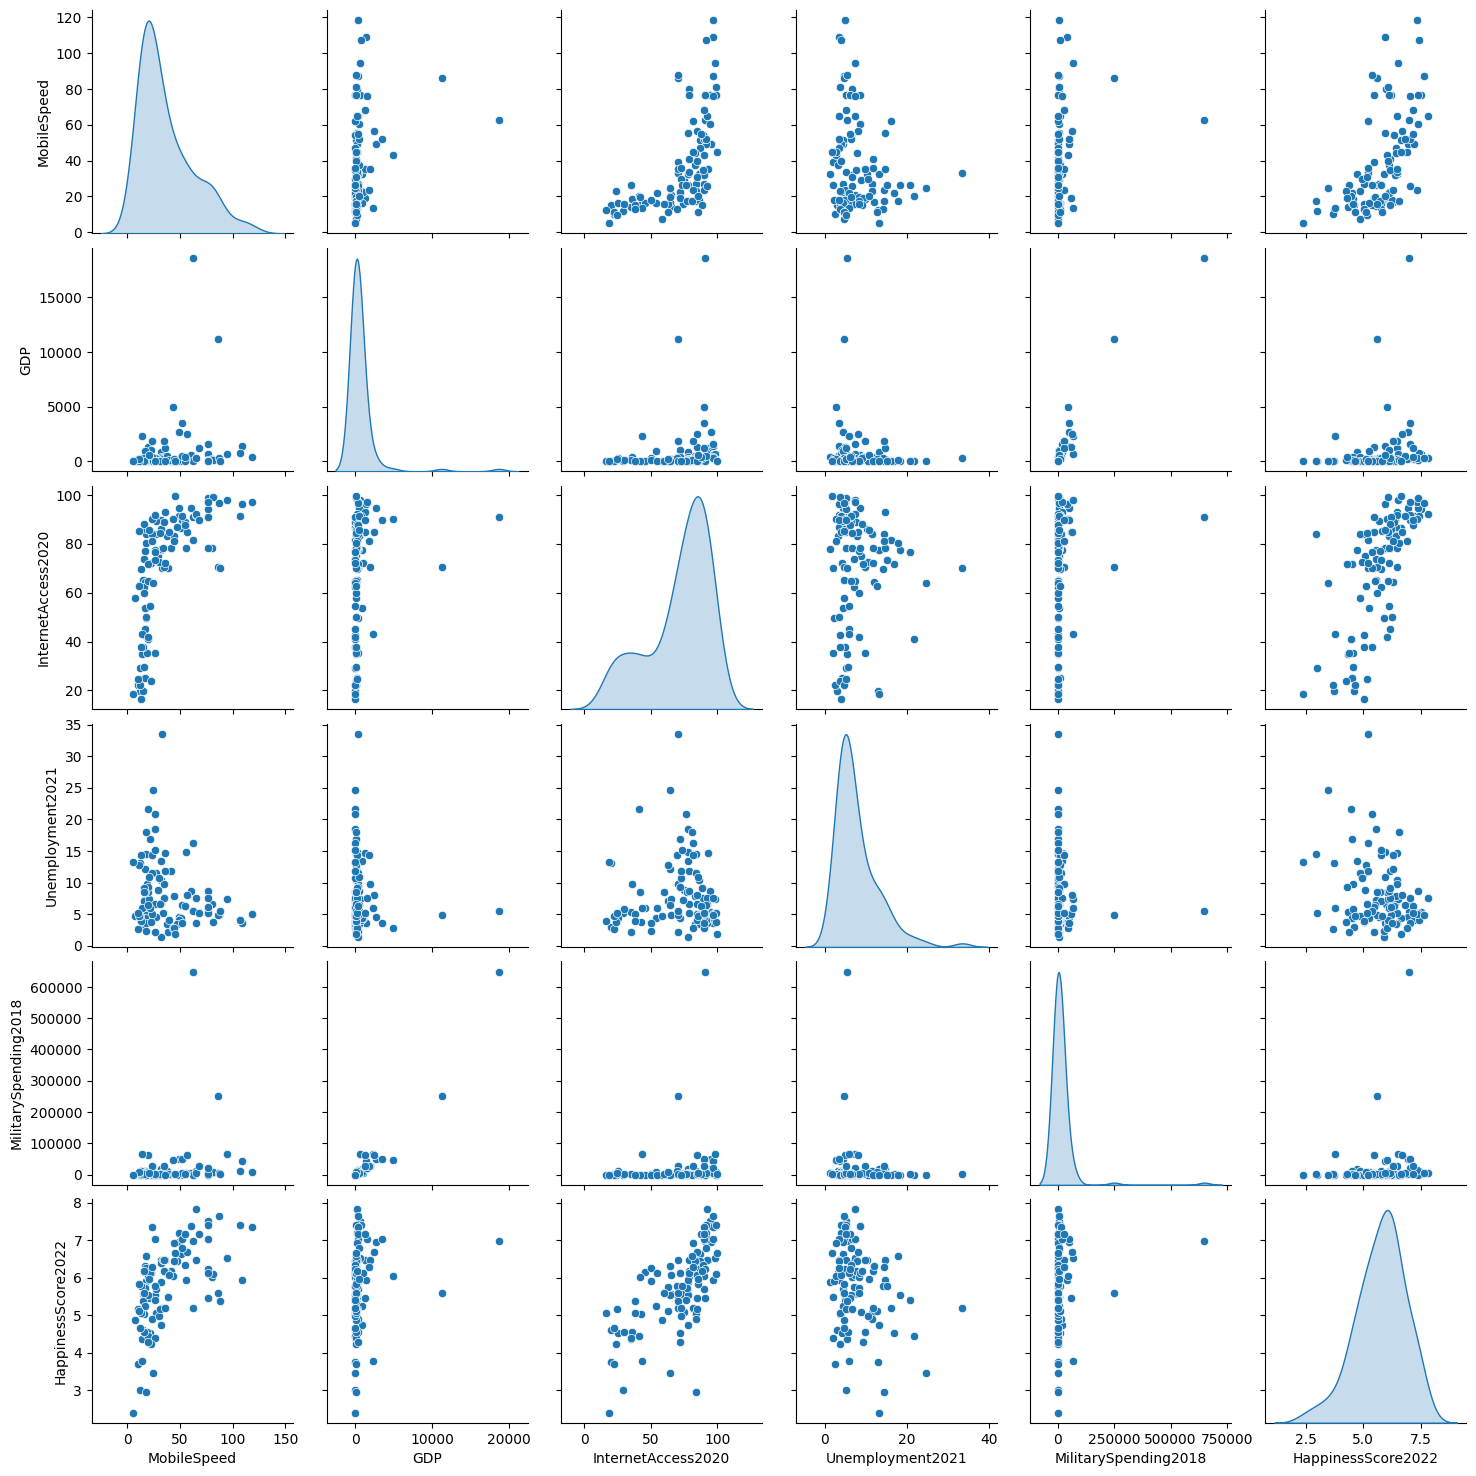

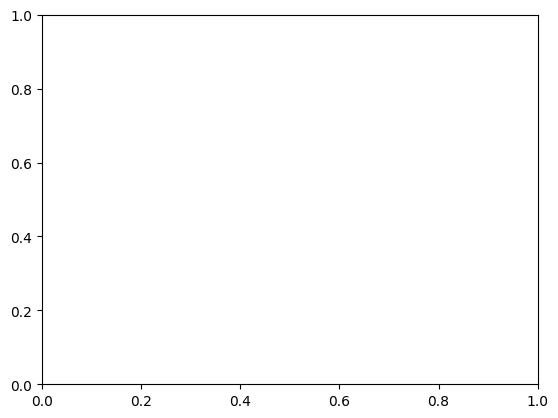

In [67]:
tmpMobile = dataset.drop('CountryCode', axis=1)
tmpMobile.drop('CountryName', axis=1, inplace=True)
tmpMobile.drop('YearGDP', axis=1, inplace=True)
tmpMobile.drop('YearInternetSpeed', axis=1, inplace=True)
tmpMobile.drop('BroadbandSpeed', axis=1, inplace=True)

tmpMobile = tmpMobile.dropna()

plot = sns.pairplot(tmpMobile[['MobileSpeed', 'GDP', 'InternetAccess2020', 'Unemployment2021', 'MilitarySpending2018', 'HappinessScore2022']], diag_kind='kde')
plot.savefig(r'..\output\Mobile Speed - Pair plot.png')
plt.show()

Pair plot - Broadband Speed

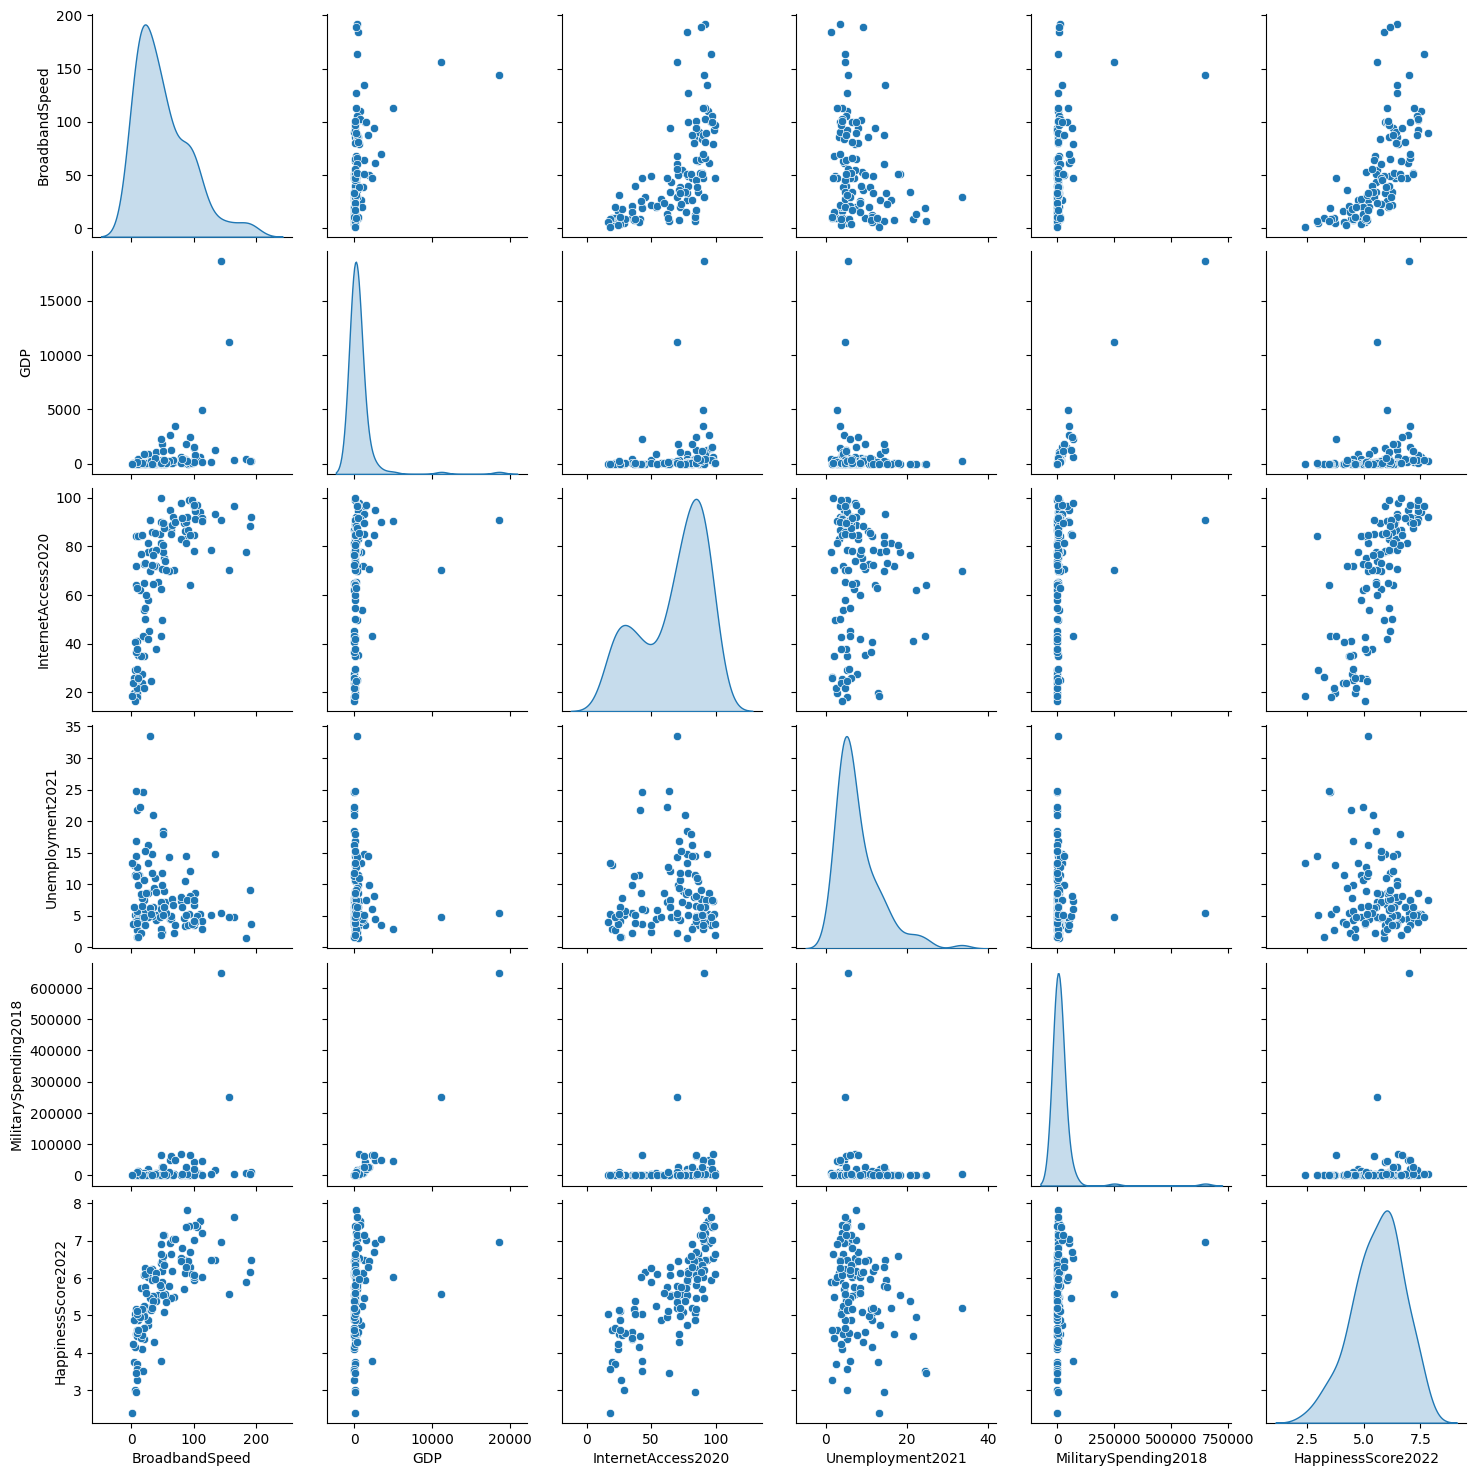

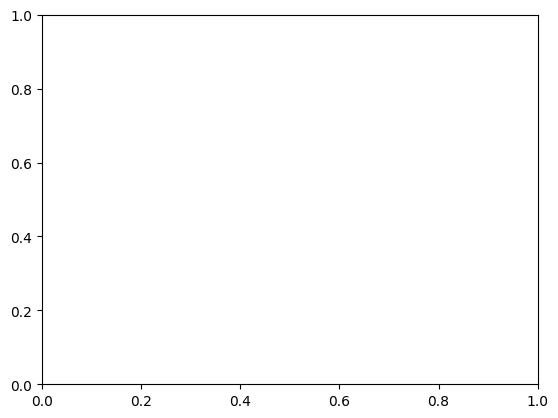

In [68]:
tmpBroadband = dataset.drop('CountryCode', axis=1)
tmpBroadband.drop('CountryName', axis=1, inplace=True)
tmpBroadband.drop('YearGDP', axis=1, inplace=True)
tmpBroadband.drop('YearInternetSpeed', axis=1, inplace=True)
tmpBroadband.drop('MobileSpeed', axis=1, inplace=True)

tmpBroadband = tmpBroadband.dropna()

plot = sns.pairplot(tmpBroadband[['BroadbandSpeed', 'GDP', 'InternetAccess2020', 'Unemployment2021', 'MilitarySpending2018', 'HappinessScore2022']], diag_kind='kde')
plot.savefig(r'..\output\Broadband Speed - Pair plot')
plt.show()

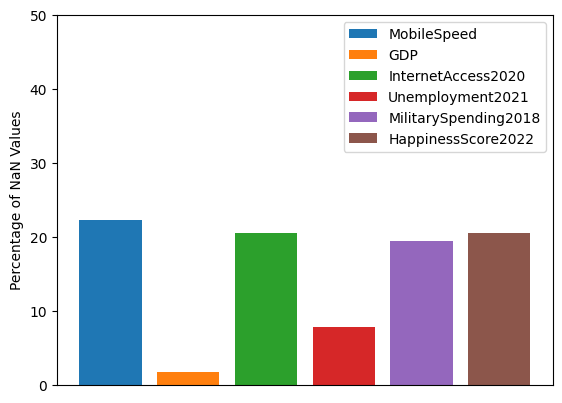

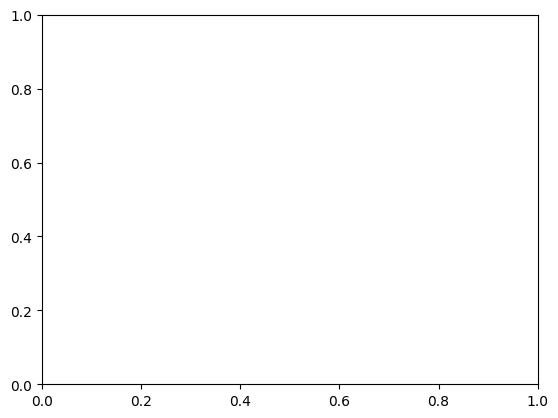

In [69]:
percent = dataset.isna().mean().round(4) * 100
f, ax = plt.subplots()
percent.drop('YearGDP', axis=0, inplace=True)

for i,item in enumerate(zip(percent.keys(),percent.values)):
    if (item[1] > 0):
        ax.bar(item[0], item[1], label = item[0])
        #ax.text(i - 0.25, item[1] + 1.5 , str(np.round(item[1],2)))

ax.set_xticklabels([]) 
ax.set_xticks([])
plt.ylim(0,50)
plt.ylabel('Percentage of NaN Values')
plt.legend()
plt.savefig(r'..\output\NaN Values.png')
plt.show()

Visualize Neural Network

In [70]:
def utils_nn_config(model):
    lst_layers = []
    if "Sequential" in str(model): #-> Sequential doesn't show the input layer
        layer = model.layers[0]
        lst_layers.append({"name":"input", "in":int(layer.input.shape[-1]), "neurons":0,
                           "out":int(layer.input.shape[-1]), "activation":None,
                           "params":0, "bias":0})
    for layer in model.layers:
        try:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":layer.units,
                         "out":int(layer.output.shape[-1]), "activation":layer.get_config()["activation"],
                         "params":layer.get_weights()[0], "bias":layer.get_weights()[1]}
        except:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":0,
                         "out":int(layer.output.shape[-1]), "activation":None,
                         "params":0, "bias":0}
        lst_layers.append(dic_layer)
    return lst_layers

def visualize_nn(model, filename, description=False, figsize=(10,8)):
    ## get layers info
    lst_layers = utils_nn_config(model)
    layer_sizes = [layer["out"] for layer in lst_layers]

    ## fig setup
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set(title=model.name)
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right-left) / float(len(layer_sizes)-1)
    y_space = (top-bottom) / float(max(layer_sizes))
    p = 0.025

    ## nodes
    for i,n in enumerate(layer_sizes):
        top_on_layer = y_space*(n-1)/2.0 + (top+bottom)/2.0
        layer = lst_layers[i]
        color = "green" if i in [0, len(layer_sizes)-1] else "blue"
        color = "red" if (layer['neurons'] == 0) and (i > 0) else color

        ### add description
        if (description is True):
            d = i if i == 0 else i-0.5
            if layer['activation'] is None:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
            else:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
                plt.text(x=left+d*x_space, y=top-p, fontsize=10, color=color, s=layer['activation']+" (")
                plt.text(x=left+d*x_space, y=top-2*p, fontsize=10, color=color, s="Σ"+str(layer['in'])+"[X*w]+b")
                out = " Y"  if i == len(layer_sizes)-1 else " out"
                plt.text(x=left+d*x_space, y=top-3*p, fontsize=10, color=color, s=") = "+str(layer['neurons'])+out)

        ### circles
        for m in range(n):
            color = "limegreen" if color == "green" else color
            circle = plt.Circle(xy=(left+i*x_space, top_on_layer-m*y_space-4*p), radius=y_space/4.0, color=color, ec='k', zorder=4)
            ax.add_artist(circle)

            ### add text
            if i == 0:
                plt.text(x=left-4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$X_{'+str(m+1)+'}$')
            elif i == len(layer_sizes)-1:
                plt.text(x=right+4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$y_{'+str(m+1)+'}$')
            else:
                plt.text(x=left+i*x_space+p, y=top_on_layer-m*y_space+(y_space/8.+0.01*y_space)-4*p, fontsize=10, s=r'$H_{'+str(m+1)+'}$')

    ## links
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer = lst_layers[i+1]
        color = "green" if i == len(layer_sizes)-2 else "blue"
        color = "red" if layer['neurons'] == 0 else color
        layer_top_a = y_space*(n_a-1)/2. + (top+bottom)/2. -4*p
        layer_top_b = y_space*(n_b-1)/2. + (top+bottom)/2. -4*p
        for m in range(n_a):
            for o in range(n_b):
                line = plt.Line2D([i*x_space+left, (i+1)*x_space+left],
                                  [layer_top_a-m*y_space, layer_top_b-o*y_space],
                                  c=color, alpha=0.5)
                if layer['activation'] is None:
                    if o == m:
                        ax.add_artist(line)
                else:
                    ax.add_artist(line)
    plt.savefig(fr'..\output\{filename}.png')
    plt.show()

Pair plot - Mobile Speed

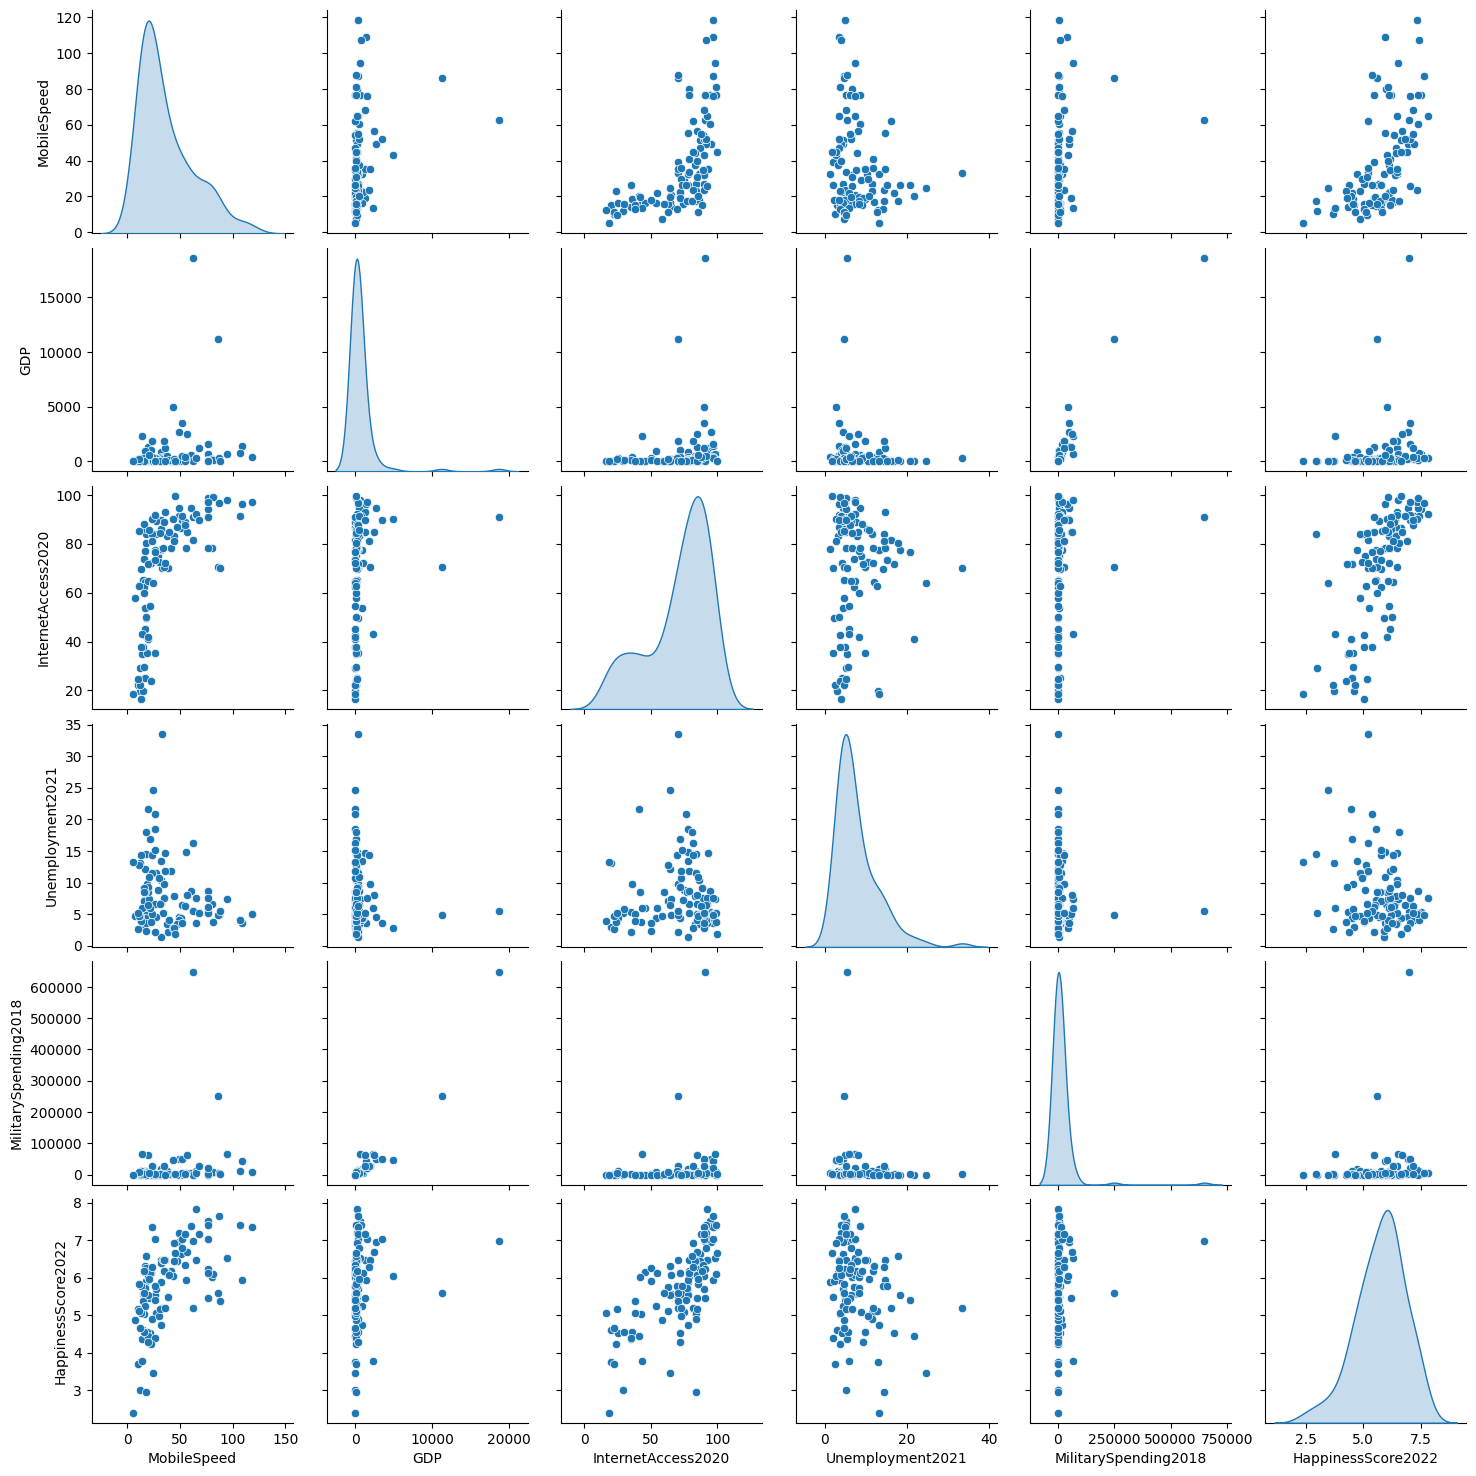

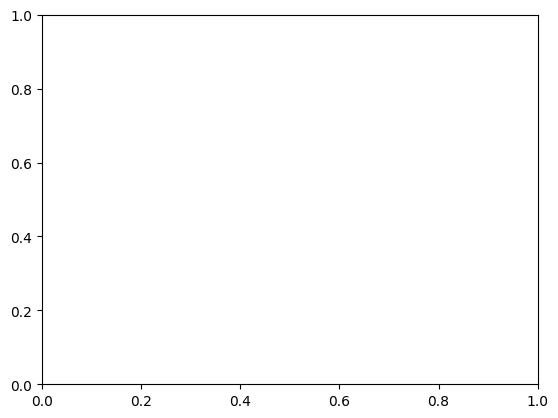

In [71]:
tmpMobile = dataset.drop('CountryCode', axis=1)
tmpMobile.drop('CountryName', axis=1, inplace=True)
tmpMobile.drop('YearGDP', axis=1, inplace=True)
tmpMobile.drop('YearInternetSpeed', axis=1, inplace=True)
tmpMobile.drop('BroadbandSpeed', axis=1, inplace=True)

tmpMobile = tmpMobile.dropna()

plot = sns.pairplot(tmpMobile[['MobileSpeed', 'GDP', 'InternetAccess2020', 'Unemployment2021', 'MilitarySpending2018', 'HappinessScore2022']], diag_kind='kde')
plot.savefig(r'..\output\Mobile Speed - Pair plot.png')
plt.show()

Adjusting tmpMobile

In [72]:
average = tmpMobile['MobileSpeed'].mean()
tmpMobile.insert(0, 'OverAverage', np.where(tmpMobile['MobileSpeed'] > average, 1, 0))
tmpMobile.drop('MobileSpeed', axis=1, inplace=True)

Mobile Speed - Deep Learning

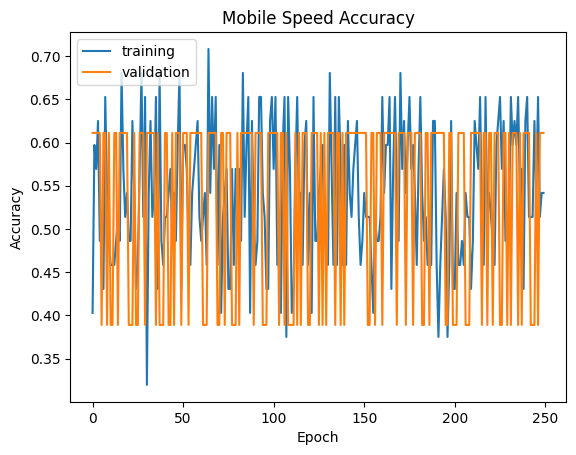

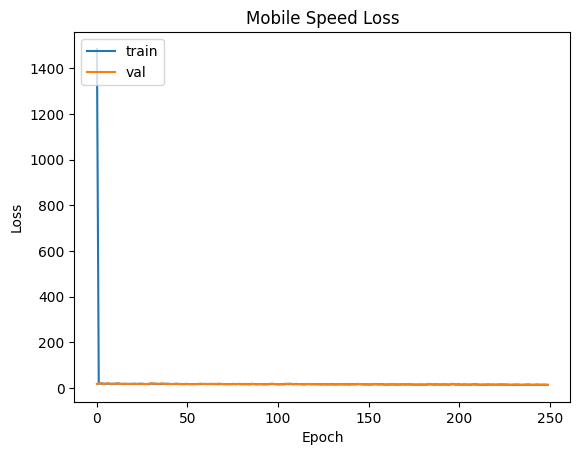

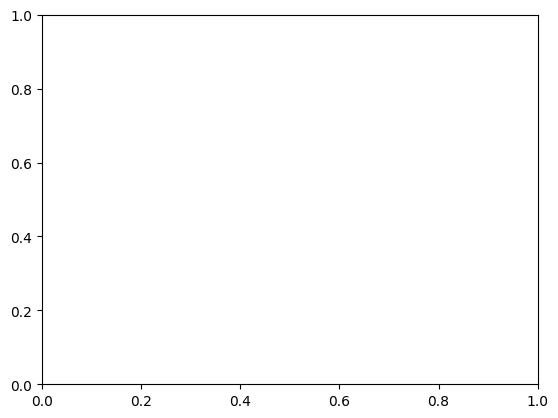

In [83]:
labels=tmpMobile['OverAverage']
features = tmpMobile.iloc[:,1:6]
X=features
y=np.ravel(labels)

model = Sequential()
model.add(Dense(3, activation='relu', input_shape=(5,)))
model.add(tensorflow.keras.layers.Dense(3, kernel_regularizer='l2'))
#model.add(Dense(3, activation='relu'))
#model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
optimizer='sgd',
metrics=['accuracy'])
training = model.fit(X, y,epochs=250, batch_size=32, verbose=0, shuffle=True, validation_split=0.33)


plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('Mobile Speed Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.savefig(r'..\output\Mobile Speed - Accuracy.png')
plt.show()



plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('Mobile Speed Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(r'..\output\Mobile Speed - Loss.png')
plt.show()

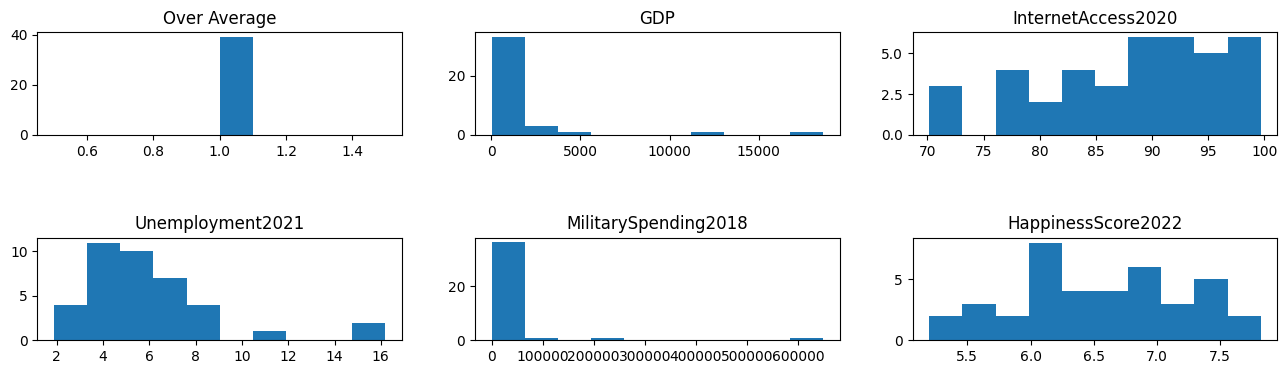

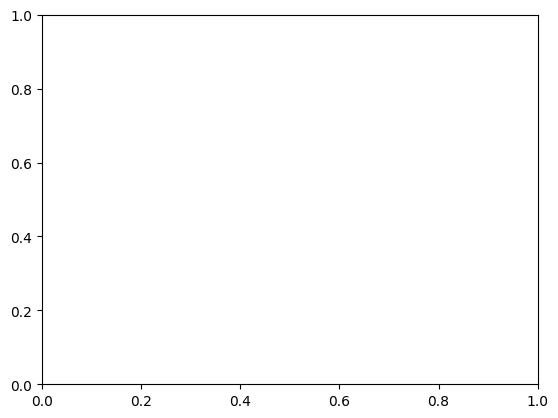

In [74]:
df = pd.DataFrame(tmpMobile, columns= np.array(tmpMobile.columns))
overAverage = df.loc[(df.OverAverage == 1)]
fig, ax = plt.subplots(2,3,figsize=(16, 4) )
i = 0
j = 0
for c in overAverage.columns[0:]:
    ax[j,i].hist(overAverage[c])
    ax[j,i].set_title(c)
    i = i + 1
    if i == 3:
        j = 1
        i = 0
ax[0,0].set_title("Over Average")
fig.subplots_adjust(hspace=1, wspace=0.2)


plt.savefig(r'..\output\Mobile Speed - Over Average.png')
plt.show()

Mobile Speeds - UnderAverage

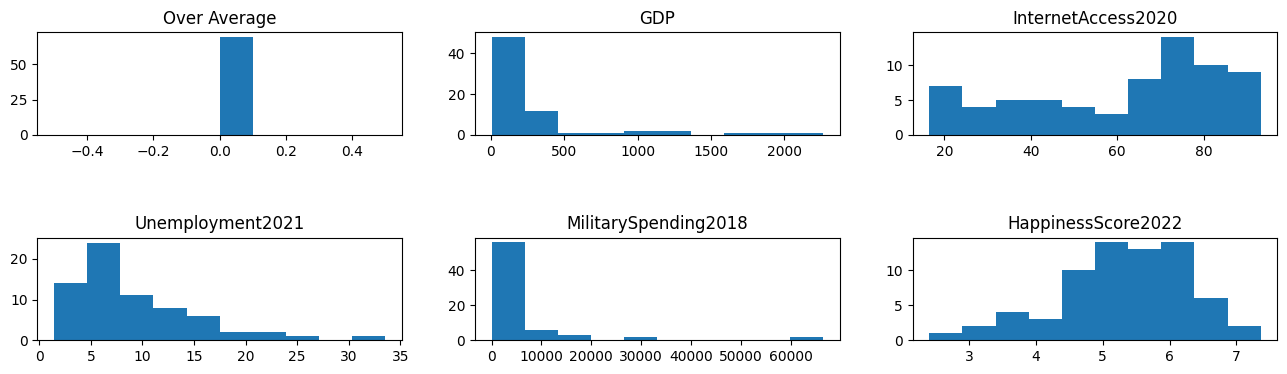

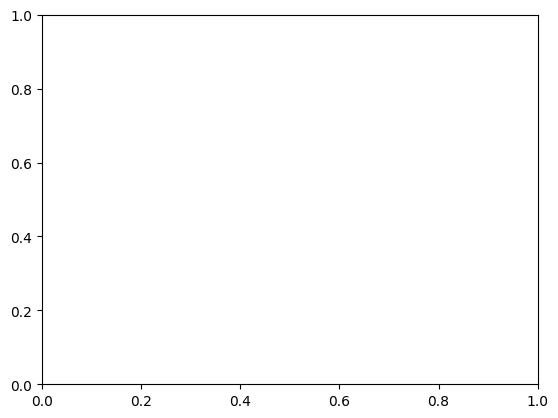

In [75]:
df = pd.DataFrame(tmpMobile, columns= np.array(tmpMobile.columns))
overAverage = df.loc[(df.OverAverage == 0)]
fig, ax = plt.subplots(2,3,figsize=(16, 4) )
i = 0
j = 0
for c in overAverage.columns[0:]:
    ax[j,i].hist(overAverage[c])
    ax[j,i].set_title(c)
    i = i + 1
    if i == 3:
        j = 1
        i = 0
ax[0,0].set_title("Over Average")
fig.subplots_adjust(hspace=1, wspace=0.2)


plt.savefig(r'..\output\Mobile Speed - Under Average.png')
plt.show()

Mobile Speed - Neural Network

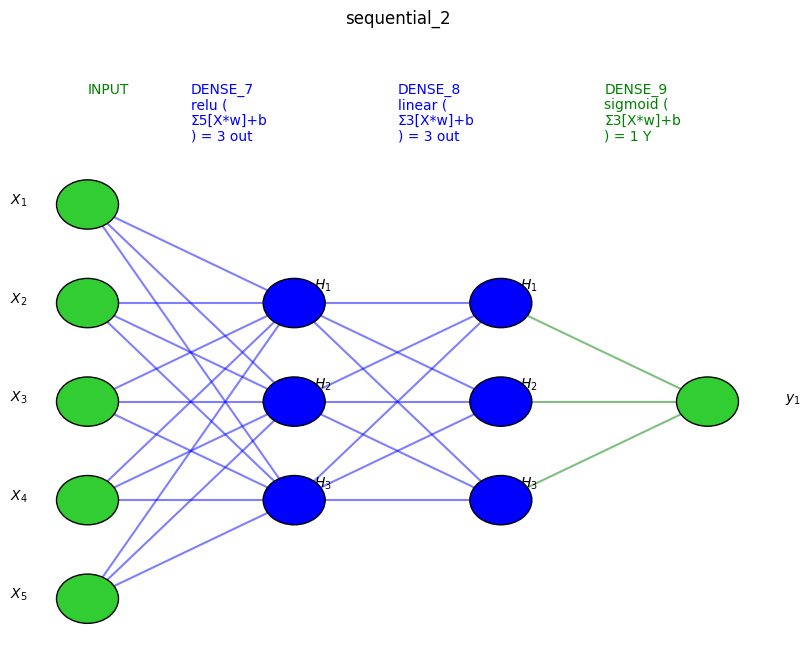

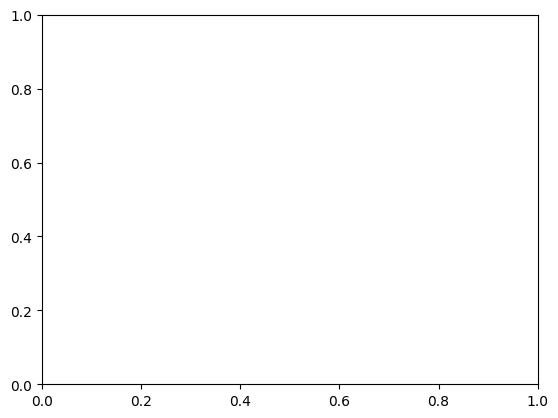

In [76]:
visualize_nn(model, 'Mobile Speed - Neural Network', description=True, figsize=(10,8))

Pair plot - Broadband Speed

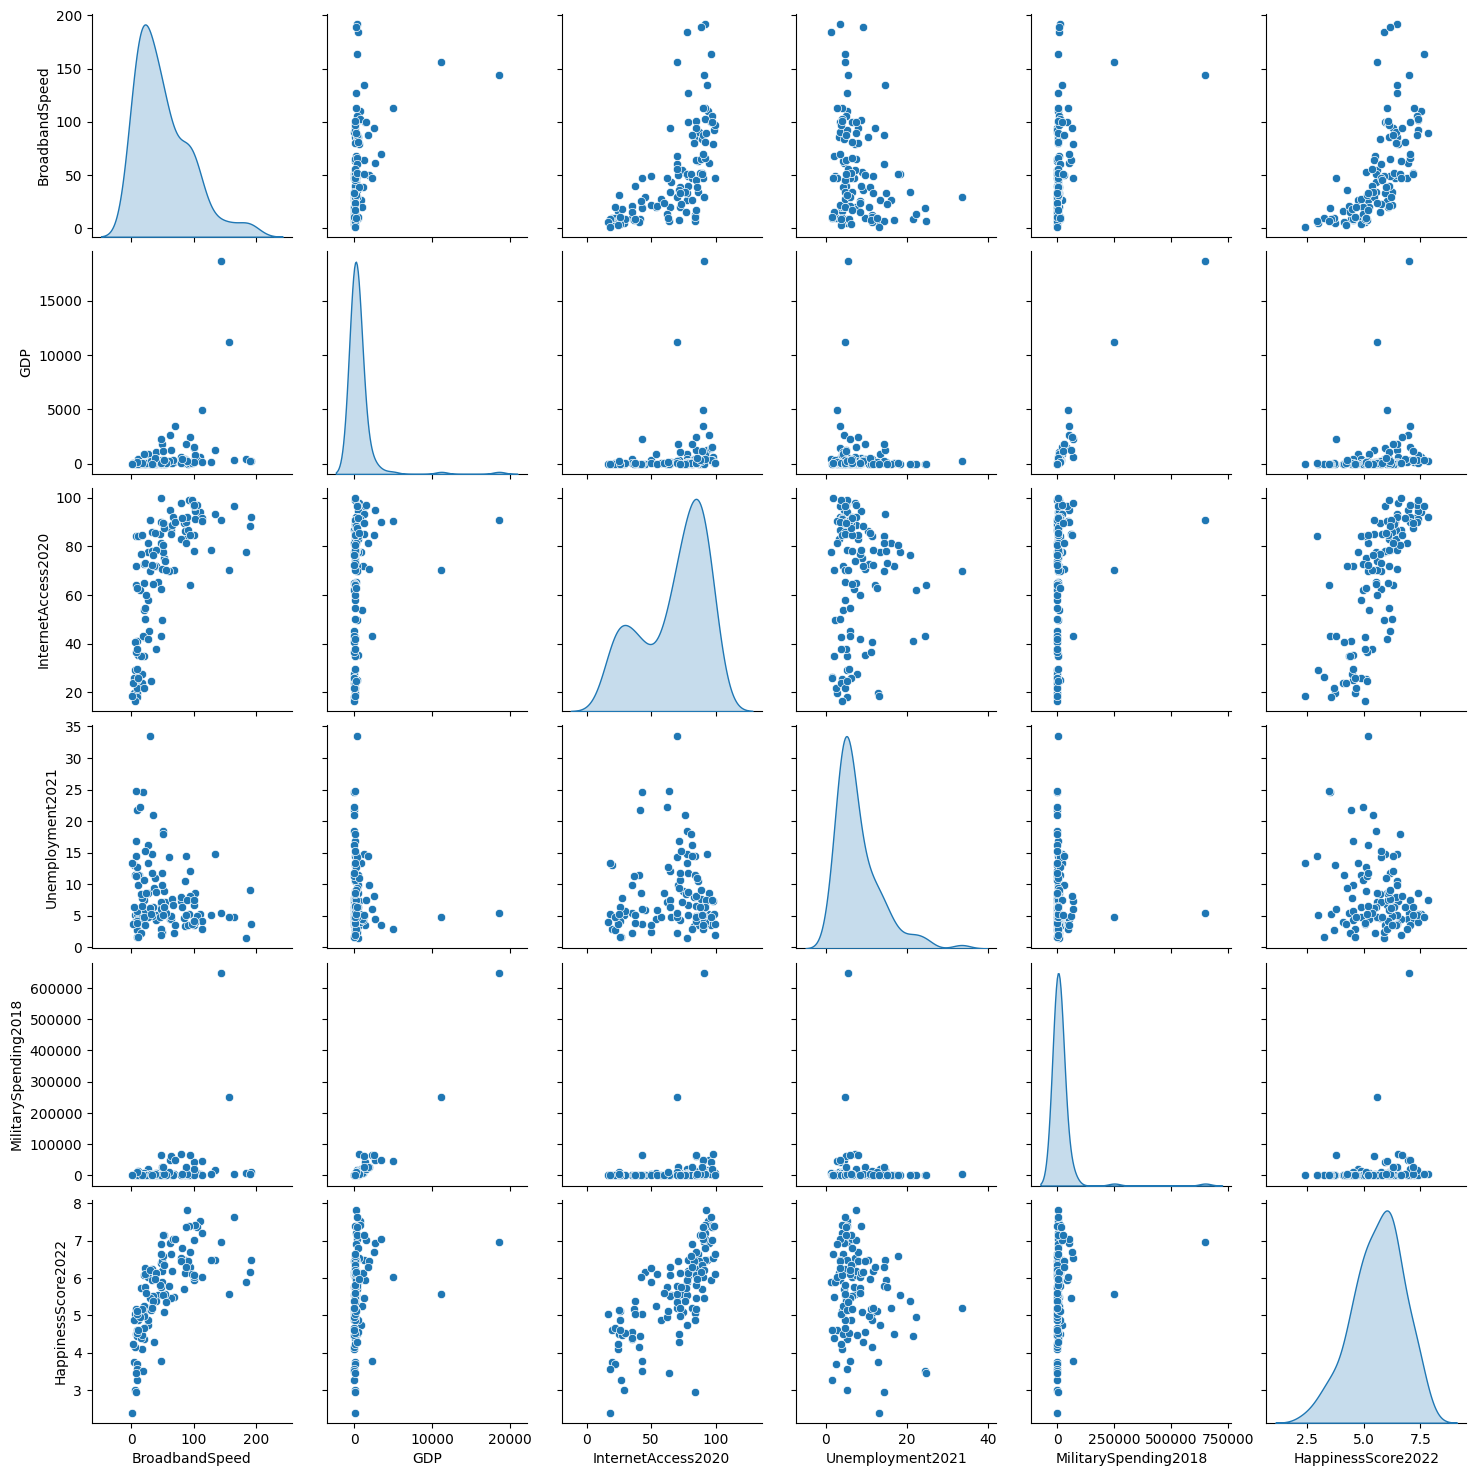

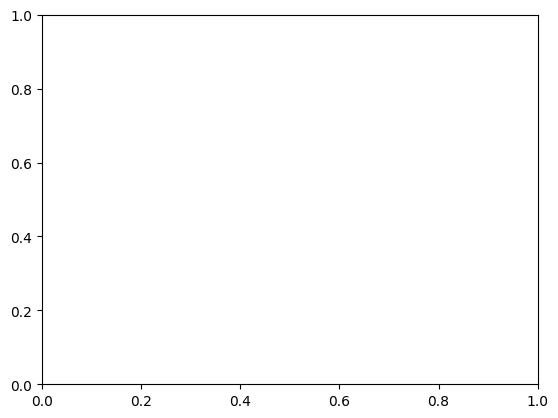

In [77]:
tmpBroadband = dataset.drop('CountryCode', axis=1)
tmpBroadband.drop('CountryName', axis=1, inplace=True)
tmpBroadband.drop('YearGDP', axis=1, inplace=True)
tmpBroadband.drop('YearInternetSpeed', axis=1, inplace=True)
tmpBroadband.drop('MobileSpeed', axis=1, inplace=True)

tmpBroadband = tmpBroadband.dropna()

plot = sns.pairplot(tmpBroadband[['BroadbandSpeed', 'GDP', 'InternetAccess2020', 'Unemployment2021', 'MilitarySpending2018', 'HappinessScore2022']], diag_kind='kde')
plot.savefig(r'..\output\Broadband Speed - Pair plot.png')
plt.show()

Adjusting tmpBroadband

In [78]:
average = tmpBroadband['BroadbandSpeed'].mean()
tmpBroadband.insert(0, 'OverAverage', np.where(tmpBroadband['BroadbandSpeed'] > average, 1, 0))
tmpBroadband.drop('BroadbandSpeed', axis=1, inplace=True)

Broadband Speed - Deep Learning

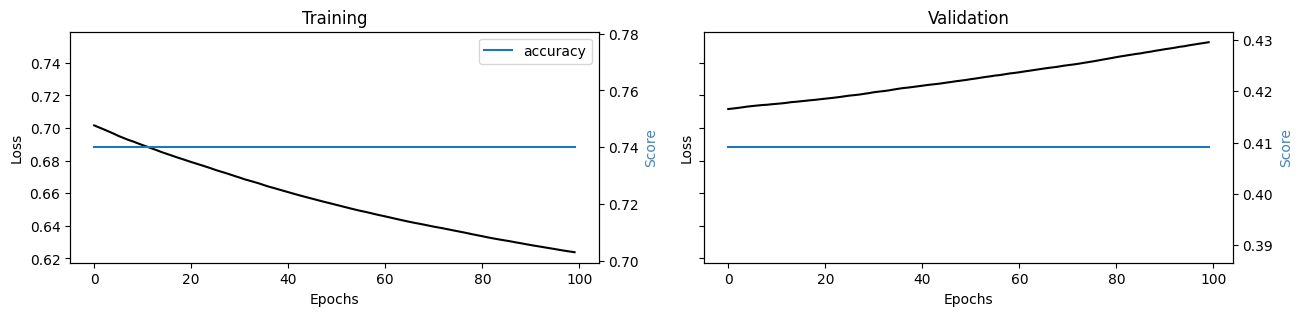

2/2 [==============================] - 0s 3ms/step - loss: 0.6696 - accuracy: 0.6389
[0.6696192622184753, 0.6388888955116272]


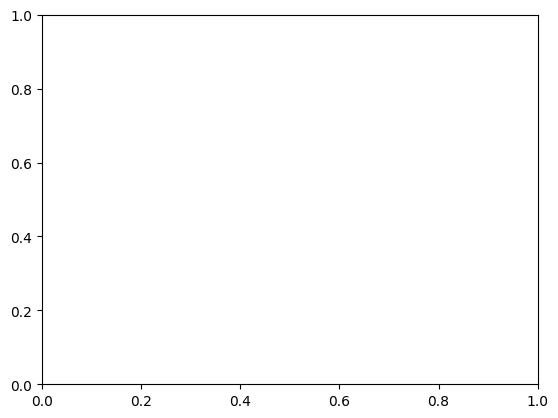

In [79]:
labels=tmpBroadband['OverAverage']
features = tmpBroadband.iloc[:,1:6]
X=features
y=np.ravel(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()
model.add(Dense(3, activation='relu', input_shape=(5,)))
model.add(tensorflow.keras.layers.Dense(3, kernel_regularizer='l2'))
#model.add(Dense(3, activation='relu'))
#model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
optimizer='sgd',
metrics=['accuracy'])
training = model.fit(X, y,epochs=250, batch_size=32, verbose=0, shuffle=True, validation_split=0.33)


plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('Broadband Speed Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.savefig(r'..\output\Broadband Speed - Accuracy.png')
plt.show()



plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('Broadband Speed Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(r'..\output\Broadband Speed - Loss.png')
plt.show()

Broadband Speed - Over Average

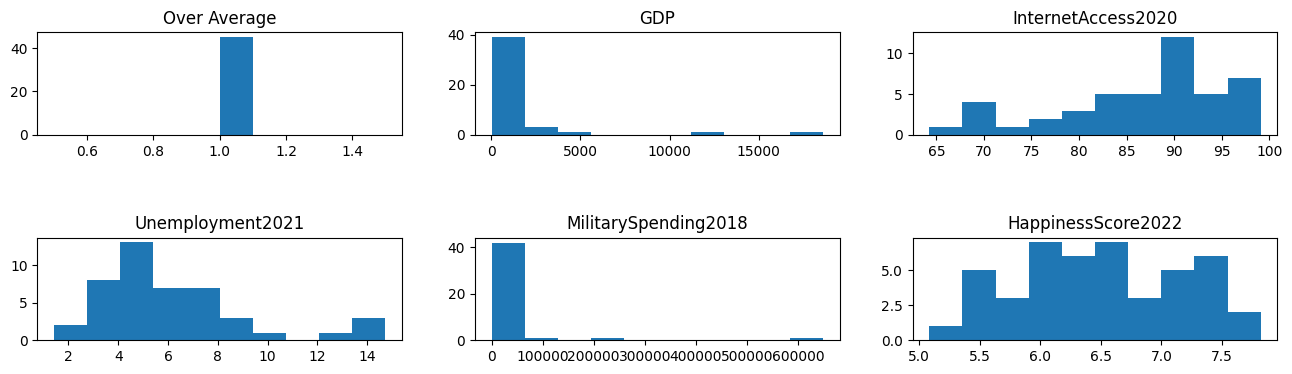

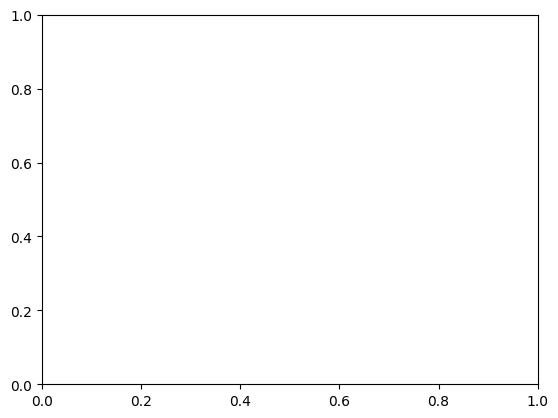

In [80]:
df = pd.DataFrame(tmpBroadband, columns= np.array(tmpBroadband.columns))
overAverage = df.loc[(df.OverAverage == 1)]
fig, ax = plt.subplots(2,3,figsize=(16, 4) )
i = 0
j = 0
for c in overAverage.columns[0:]:
    ax[j,i].hist(overAverage[c])
    ax[j,i].set_title(c)
    i = i + 1
    if i == 3:
        j = 1
        i = 0
ax[0,0].set_title("Over Average")
fig.subplots_adjust(hspace=1, wspace=0.2)


plt.savefig(r'..\output\Broadband Speed - Over Average.png')
plt.show()

Broadband Speed - Under Average

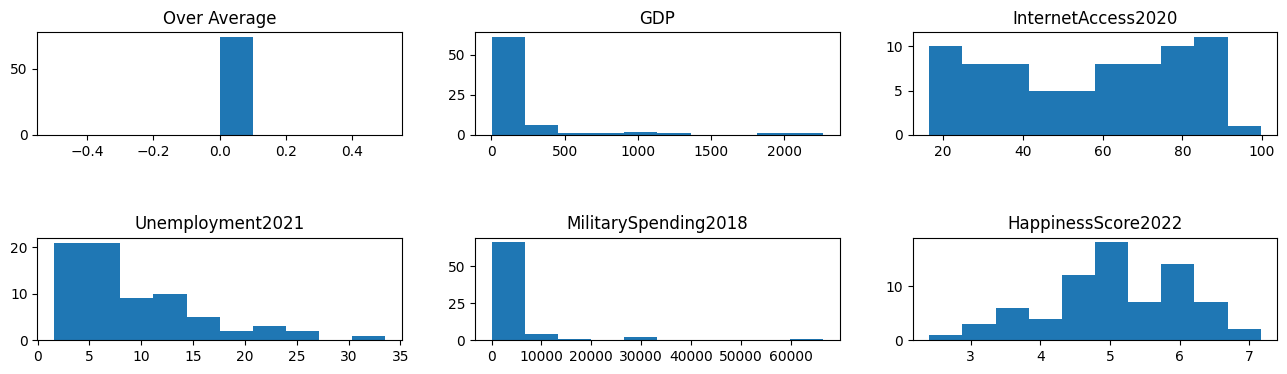

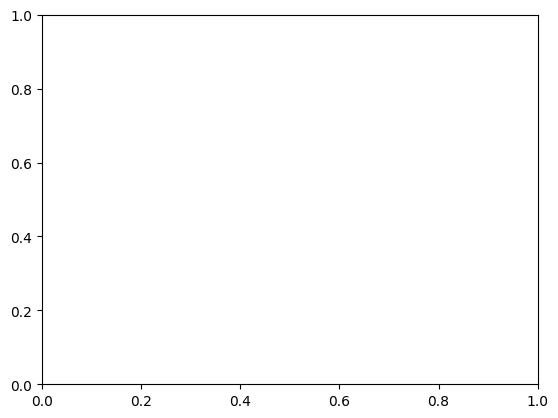

In [81]:
df = pd.DataFrame(tmpBroadband, columns= np.array(tmpBroadband.columns))
overAverage = df.loc[(df.OverAverage == 0)]
fig, ax = plt.subplots(2,3,figsize=(16, 4) )
i = 0
j = 0
for c in overAverage.columns[0:]:
    ax[j,i].hist(overAverage[c])
    ax[j,i].set_title(c)
    i = i + 1
    if i == 3:
        j = 1
        i = 0
ax[0,0].set_title("Over Average")
fig.subplots_adjust(hspace=1, wspace=0.2)


plt.savefig(r'..\output\Broadband Speed - Under Average.png')
plt.show()

Broadband Speed - Create Neural Network Graph

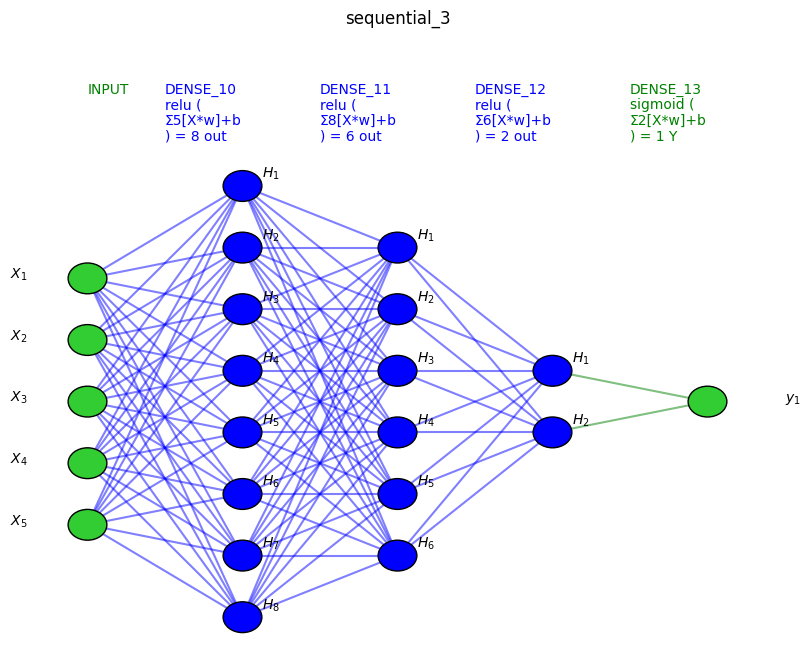

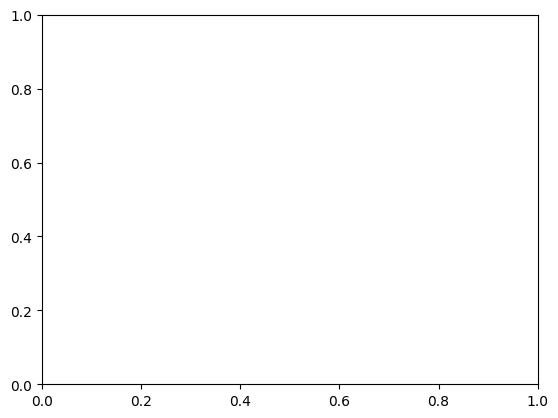

In [82]:
visualize_nn(model, 'Broadband Speed - Neural Network', description=True, figsize=(10,8))